## Общие действия

In [1]:
# Импортируем все необходимое
import ast
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
# Сделаем так, чтобы matplotlib рисовал все сразу без напоминаний
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зададим:
# - общий параметр для генерации случайных чисел
RANDOM_SEED = 42
# - общую текущую дату
CURRENT_DATE = pd.to_datetime('22/02/2020')

In [4]:
# Для тех, кто будет запускать мой ноутбук на своей машине создаем requirements.txt
!pip freeze > requirements.txt

In [5]:
# Зададим путь к папке с данными
ds_folder = 'data'

# Зададим названия файлов датасетов
mt_ds = 'main_task.csv'
kt_ds = 'kaggle_task.csv'
new_ds = 'new_data.csv'

# Сформируем пути к датасетам
mt_path = join(ds_folder, mt_ds)
kt_path = join(ds_folder, kt_ds)
new_path = join(ds_folder, new_ds)

# Загрузим имеющиеся датасеты
mt_df = pd.read_csv(mt_path)
kt_df = pd.read_csv(kt_path)
new_df = pd.read_csv(new_path)

In [6]:
# Проанализируем данные из main_task.csv
mt_df.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


In [7]:
mt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
mt_df.nunique()

Restaurant_id        11909
City                    31
Cuisine Style         9007
Ranking              11936
Rating                   9
Price Range              3
Number of Reviews     1459
Reviews              33516
URL_TA               39980
ID_TA                39980
dtype: int64

## Инсайт!!!
Из анализа количества уникальных значений можно сделать следующие выводы:
- Поле Restaurant_id является чем угодно, но только не уникальным идентификатором ресторана. Ориентироваться на эти данные не стоит. 
- На роль уникальных идентификаторов скорее могут претендовать в равной степени как URL_TA, так и ID_TA. Но и тут наблюдаются дубликаты. Посмотрим на них внимательней: 

In [9]:
# Сформируем множество дублирующихся идентификаторов ресторанов на сайте TripAdvisor
duplicated_ids = set(mt_df.groupby('ID_TA')['ID_TA'].count().sort_values(ascending=False)[:20].index)

# Смотрим на непосредственно данные, относящиеся к этим дубликатам
mt_df[mt_df['ID_TA'].apply(lambda x: x in duplicated_ids)].sort_values(by='ID_TA')

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
38946,id_3242,Madrid,NaN,3244.0,5.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
13980,id_3239,Madrid,NaN,3241.0,5.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...",3812.0,4.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...",3806.0,4.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
26551,id_3240,Madrid,NaN,3242.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26431,id_3238,Madrid,NaN,3240.0,4.5,NaN,7.0,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
10819,id_2197,Madrid,NaN,2199.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,2331.0,4.5,NaN,16.0,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3664.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...",3538.0,4.0,$$ - $$$,52.0,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


#### Эти дубликаты только вносят шум, так что от них лучше избавиться.
## Оказалось наоборот!!! Не удаляем эти дубликаты и точность модели повышается!!! Дружно кекаем!!!

In [10]:
# mt_df.drop_duplicates('ID_TA', inplace=True) # По-умолчанию оставляем первые из дублирующихся строк

In [11]:
# Проанализируем данные из kaggle_task.csv
kt_df.head(1)

,Restaurant_id,Name,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Le Perchoir,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


In [12]:
kt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
Restaurant_id        10000 non-null object
Name                 10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


In [13]:
# Как видим, в датасете kaggle_task.csv отсутствует признак Rating,
# но добавлен признак с названием ресторана 'Name'

In [14]:
# Добавим признак 'Main' для отделения основной выборки от валидационной
mt_df['Main'] = True
kt_df['Main'] = False

# Недостающие данные по названиям ресторанов в основной выборке заполним названиями вида Name-id, где id - идентификатор ресторана
mt_df['Name'] = mt_df['Restaurant_id'].apply(lambda x: 'Name-'+x)

# Недостающие данные по рейтингу в тестовой выборке заполним нулями
kt_df['Rating'] = 0

# Объединим датасеты в один для полного анализа по всем данным
df = pd.concat([mt_df, kt_df], sort=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 12 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Rating               50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
Main                 50000 non-null bool
Name                 50000 non-null object
dtypes: bool(1), float64(3), object(8)
memory usage: 4.6+ MB


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48809 entries, 0 to 48808
Data columns (total 16 columns):
Unnamed: 0               48809 non-null int64
New Name                 48809 non-null object
New City                 43829 non-null object
New Cuisine Style        45619 non-null object
New Ranking              43837 non-null float64
New Restaurants Count    43837 non-null float64
New Relative Ranking     43837 non-null float64
New Rating               48772 non-null float64
New Price Range          38980 non-null object
New Number of Reviews    47288 non-null float64
New Excellent Marks      48623 non-null float64
New Very Good Marks      48761 non-null float64
New Poor Marks           48773 non-null float64
New Terrible Marks       48773 non-null float64
New URL_TA               48809 non-null object
New Is Closed            48809 non-null bool
dtypes: bool(1), float64(9), int64(1), object(5)
memory usage: 5.6+ MB


In [17]:
# Установим индексы на URL_TA
df.set_index('URL_TA', inplace=True)
new_df.set_index('New URL_TA', inplace=True)

In [19]:
# Осуществим слияние двух датафреймов оставляя данные из старого датафрейма, если они там были 
df = pd.merge(df, new_df, how='left', left_index=True, right_index=True)

In [20]:
# Посмотрим, что получилсь
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 26 columns):
Restaurant_id            50000 non-null object
City                     50000 non-null object
Cuisine Style            38410 non-null object
Ranking                  50000 non-null float64
Rating                   50000 non-null float64
Price Range              32639 non-null object
Number of Reviews        46800 non-null float64
Reviews                  49998 non-null object
ID_TA                    50000 non-null object
Main                     50000 non-null bool
Name                     50000 non-null object
Unnamed: 0               44287 non-null float64
New Name                 44287 non-null object
New City                 39614 non-null object
New Cuisine Style        41211 non-null object
New Ranking             

In [21]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,Main,...,New Restaurants Count,New Relative Ranking,New Rating,New Price Range,New Number of Reviews,New Excellent Marks,New Very Good Marks,New Poor Marks,New Terrible Marks,New Is Closed
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,id_1759,Brussels,NaN,1760.0,4.5,NaN,2.0,"[[], []]",d10441257,True,...,41.0,0.512195,4.5,NaN,7.0,4.0,3.0,0.0,0.0,False
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,id_2178,Brussels,NaN,2265.0,4.0,NaN,NaN,"[[], []]",d10486190,True,...,NaN,NaN,4.0,NaN,1.0,0.0,1.0,0.0,0.0,True
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,id_1738,Brussels,['Fusion'],1739.0,4.0,$,14.0,"[['Quick delicious lunch', 'The perfect lunch'...",d10522391,True,...,41.0,0.292683,4.5,$,21.0,7.0,0.0,0.0,1.0,False
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,id_1513,Brussels,NaN,1514.0,5.0,NaN,4.0,"[[], []]",d11888819,True,...,41.0,0.634146,4.0,NaN,6.0,4.0,1.0,0.0,1.0,False
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,id_2485,Brussels,NaN,2486.0,3.5,NaN,3.0,"[['Service with smile', 'Rather boring food'],...",d12160475,True,...,41.0,0.780488,3.5,NaN,3.0,0.0,2.0,1.0,0.0,False


## 1. Информация о ресторанах

### Добавленный числовой признак № 1. Количество ресторанов в городе

In [23]:
# Создадим справочник с указанием количества ресторанов для каждого города, присутствующего в датасете
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}

In [24]:
# Создадим новый признак 'Restaurants Count', отражающий общее количество ресторанов в городе, в котором расположен данный ресторан
df['Restaurants Count'] = df['City'].map(res_count)

In [25]:
# Смотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 27 columns):
Restaurant_id            50000 non-null object
City                     50000 non-null object
Cuisine Style            38410 non-null object
Ranking                  50000 non-null float64
Rating                   50000 non-null float64
Price Range              32639 non-null object
Number of Reviews        46800 non-null float64
Reviews                  49998 non-null object
ID_TA                    50000 non-null object
Main                     50000 non-null bool
Name                     50000 non-null object
Unnamed: 0               44287 non-null float64
New Name                 44287 non-null object
New City                 39614 non-null object
New Cuisine Style        41211 non-null object
New Ranking             

In [31]:
df['Restaurants Count'].head()

/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html             3703
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html              3703
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html            3703
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html    3703
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html                  3703
Name: Restaurants Count, dtype: int64

### Добавленный числовой признак № 2. Относительный ранг

In [32]:
# А теперь создадим относительный признак 'Relative Ranking' = 'Ranking' / 'Restaurants Count'
df['Relative Ranking'] = df['Ranking'] / df['Restaurants Count']

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 28 columns):
Restaurant_id            50000 non-null object
City                     50000 non-null object
Cuisine Style            38410 non-null object
Ranking                  50000 non-null float64
Rating                   50000 non-null float64
Price Range              32639 non-null object
Number of Reviews        46800 non-null float64
Reviews                  49998 non-null object
ID_TA                    50000 non-null object
Main                     50000 non-null bool
Name                     50000 non-null object
Unnamed: 0               44287 non-null float64
New Name                 44287 non-null object
New City                 39614 non-null object
New Cuisine Style        41211 non-null object
New Ranking             

In [34]:
df['Relative Ranking'].head()

/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html             0.475290
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html              0.611666
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html            0.469619
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html    0.408858
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html                  0.671348
Name: Relative Ranking, dtype: float64

## 2. Информация о ценах

In [35]:
# Посмотрим на данные в признаке 'Price Range'
df['Price Range'].unique()

array([nan, '$', '$$ - $$$', '$$$$'], dtype=object)

In [36]:
# Сравним с новыми данными
df['New Price Range'].unique()

array([nan, '$', '$$ - $$$', '$$$$'], dtype=object)

In [37]:
df[['Price Range', 'New Price Range']].head()

,Price Range,New Price Range
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,NaN,NaN
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,NaN,NaN
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,$,$
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,NaN,NaN
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,NaN,NaN


In [39]:
# Как видно, часть недостающих данных можно взять из колонки New Price Range
df[['Price Range', 'New Price Range']].isna().sum()

Price Range        17361
New Price Range    15132
dtype: int64

In [45]:
# Берем недостающие данные из колонки New Price Range
df.loc[df['Price Range'].isna(), 'Price Range'] = df.loc[df['Price Range'].isna(), 'New Price Range']

In [46]:
# Как видно, новые данные устранили порядка 7000 пробелов
df[['Price Range', 'New Price Range']].isna().sum()

Price Range        10278
New Price Range    15132
dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 29 columns):
Restaurant_id            50000 non-null object
City                     50000 non-null object
Cuisine Style            38410 non-null object
Ranking                  50000 non-null float64
Rating                   50000 non-null float64
Price Range              39722 non-null object
Number of Reviews        46800 non-null float64
Reviews                  49998 non-null object
ID_TA                    50000 non-null object
Main                     50000 non-null bool
Name                     50000 non-null object
Unnamed: 0               44287 non-null float64
New Name                 44287 non-null object
New City                 39614 non-null object
New Cuisine Style        41211 non-null object
New Ranking             

In [49]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,Main,...,New Price Range,New Number of Reviews,New Excellent Marks,New Very Good Marks,New Poor Marks,New Terrible Marks,New Is Closed,Restaurants Count,Relative Ranking,Price Range Was NAN
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,id_1759,Brussels,NaN,1760.0,4.5,NaN,2.0,"[[], []]",d10441257,True,...,NaN,7.0,4.0,3.0,0.0,0.0,False,3703,0.475290,True
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,id_2178,Brussels,NaN,2265.0,4.0,NaN,NaN,"[[], []]",d10486190,True,...,NaN,1.0,0.0,1.0,0.0,0.0,True,3703,0.611666,True
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,id_1738,Brussels,['Fusion'],1739.0,4.0,$,14.0,"[['Quick delicious lunch', 'The perfect lunch'...",d10522391,True,...,$,21.0,7.0,0.0,0.0,1.0,False,3703,0.469619,False
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,id_1513,Brussels,NaN,1514.0,5.0,NaN,4.0,"[[], []]",d11888819,True,...,NaN,6.0,4.0,1.0,0.0,1.0,False,3703,0.408858,True
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,id_2485,Brussels,NaN,2486.0,3.5,NaN,3.0,"[['Service with smile', 'Rather boring food'],...",d12160475,True,...,NaN,3.0,0.0,2.0,1.0,0.0,False,3703,0.671348,True


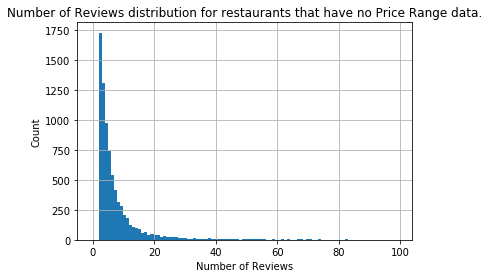

In [50]:
# Как видно, кроме незаполненных данных есть три типа диапазонов цен '$', '$$-$$$' и '$$$$'.
# Посмотрим на гистограмму количества отзывов для тех ресторанов, по которым отсутствует
# информация о диапазоне цен.
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('Number of Reviews distribution for restaurants that have no Price Range data.')
df[df['Price Range'].isna()]['Number of Reviews'].hist(bins=100, range=(0, 99))

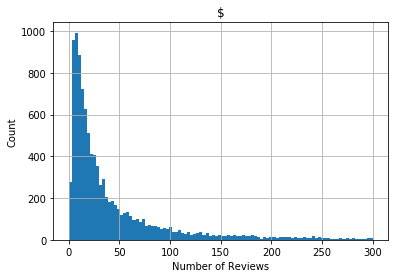

In [51]:
# Посмотрим на гистаграмму распределения количества отзывов 
# о ресторанах для разных диапазонов цен.
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('$')
df[df['Price Range'] == '$']['Number of Reviews'].hist(bins=100, range=(0, 300))

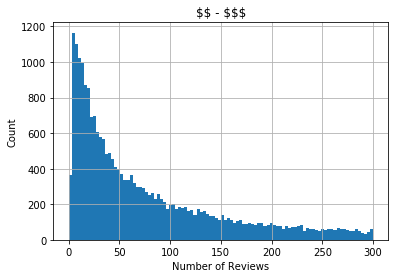

In [52]:
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('\$\$ - \$\$\$')
df[df['Price Range'] == '$$ - $$$']['Number of Reviews'].hist(bins=100, range=(0, 300))

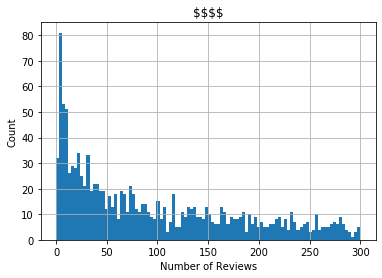

In [53]:
plt.xlabel('Number of Reviews')
plt.ylabel('Count')
plt.title('\$\$\$\$')
df[df['Price Range'] == '$$$$']['Number of Reviews'].hist(bins=100, range=(0, 300))

### Инсайт!!!
На гистограмме видно, что у большинства ресторанов с отсутствующими данными по диапазону цен количество отзывов меньше 40.
Из этого можно сделать вывод, что такие рестораны появились относительно недавно и данных по ним недостаточно.
Будем исходить из предположения, что в новых ресторанах уровень цен минимальный, так как им нужно сначала приобрести клиентуру.
Заполним недостающие данные по уровню цен таким образом:
- При 0-5 отзывов уровень цен будет минимальным '\\$'
- При 5+ отзывов уровень цен будет средним '\\$\\$ - \\$\\$\\$'

# Забегая вперед... Как ни странно, это не сработало. Точность лучше, если просто заполнить пропуски значением '\\$\\$ - \\$\\$\\$'. Дружно кекаем!!!

### Добавленный числовой признак №3. Отсутствующие данные в столбце 'Price Range'

In [54]:
# Перед заполнением пропусков создадим бинарный признак того, что раньше здесь был NAN
df['Price Range Was NAN'] = df['Price Range'].isna()
# Заполним пропуски данными функции get_price_range
# df['Price Range'].fillna(df['Number of Reviews'].apply(get_price_range), inplace=True)
# Ну уж нет. Заполним тупо значением '$$ - $$$' через fillna()
df['Price Range'].fillna('$$ - $$$', inplace=True)

### Добавленный числовой признак №4. Отсутствующие данные в столбце 'Number of Reviews'

In [55]:
# Для начала создадим бинарный признак о том, было ли пропущено значение в поле 'Number of Reviews
df['Number of Reviews Was NAN'] = df['Number of Reviews'].isna()
# Заполним недостающие данные по количеству отзывов единицами
df['Number of Reviews'].fillna(1, inplace=True)

### Добавленный числовой признак №5. Числовой код диапазона цен

In [56]:
# Теперь самое время перевести признак Price Range в числовой формат.
# Так как число вариаций диапазонов цен не велико сэкономим память и вычисления
# переведя строки в числа при помощи словаря и метода map вместо использования
# sklearn.preprocessing.LabelEcnoder

price_range_dict = {
    '$': 1,
    '$$ - $$$': 100,
    '$$$$': 1000
}

df['Price Range'] = df['Price Range'].map(price_range_dict)

## 2. География

In [57]:
# Еще раз посмотрим на информацию о данных в df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 30 columns):
Restaurant_id                50000 non-null object
City                         50000 non-null object
Cuisine Style                38410 non-null object
Ranking                      50000 non-null float64
Rating                       50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
Reviews                      49998 non-null object
ID_TA                        50000 non-null object
Main                         50000 non-null bool
Name                         50000 non-null object
Unnamed: 0                   44287 non-null float64
New Name                     44287 non-null object
New City                     39614 non-null object
New Cuisine Styl

In [58]:
# Как видим, информация о городах присутствует для всех ресторанов
# Посмотрим в скольких разных городах расположены рестораны, данные по которым присутствуют в датасете
df['City'].nunique()

31

In [59]:
# Посмотрим, как рестораны распределены по городам
df.groupby('City')['City'].count().sort_values(ascending=False)

City
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

### Добавленный числовой признак №6. Код города

In [60]:
# Переведем информацию о городах в числовой формат
# с применением sklearn.preprocessign.LabelEncoder
cities_le = LabelEncoder()
cities_le.fit(df['City'])
df['City Code'] = cities_le.transform(df['City'])

In [61]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,Main,...,New Excellent Marks,New Very Good Marks,New Poor Marks,New Terrible Marks,New Is Closed,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,id_1759,Brussels,NaN,1760.0,4.5,100,2.0,"[[], []]",d10441257,True,...,4.0,3.0,0.0,0.0,False,3703,0.475290,True,False,5
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,id_2178,Brussels,NaN,2265.0,4.0,100,1.0,"[[], []]",d10486190,True,...,0.0,1.0,0.0,0.0,True,3703,0.611666,True,True,5
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,id_1738,Brussels,['Fusion'],1739.0,4.0,1,14.0,"[['Quick delicious lunch', 'The perfect lunch'...",d10522391,True,...,7.0,0.0,0.0,1.0,False,3703,0.469619,False,False,5
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,id_1513,Brussels,NaN,1514.0,5.0,100,4.0,"[[], []]",d11888819,True,...,4.0,1.0,0.0,1.0,False,3703,0.408858,True,False,5
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,id_2485,Brussels,NaN,2486.0,3.5,100,3.0,"[['Service with smile', 'Rather boring food'],...",d12160475,True,...,0.0,2.0,1.0,0.0,False,3703,0.671348,True,False,5


In [62]:
# Создадим словарь, в котором ключами буду названия городов, а значениями True, если этот город столица, в противном случае False
is_capital = {
    'London': True,
    'Paris': True,
    'Madrid': True,
    'Barcelona': False,
    'Berlin': True,
    'Milan': False,
    'Rome': True,
    'Prague': True,
    'Lisbon': True,
    'Vienna': True,
    'Amsterdam': True,
    'Brussels': True,
    'Hamburg': False,
    'Munich': False,
    'Lyon': False,
    'Stockholm': True,
    'Budapest': True,
    'Warsaw': True,
    'Dublin': True,
    'Copenhagen': True,
    'Athens': True,
    'Edinburgh': True,
    'Zurich': True,
    'Oporto': False,
    'Geneva': True,
    'Krakow': True,
    'Oslo': True,
    'Helsinki': True,
    'Bratislava': True,
    'Luxembourg': True,
    'Ljubljana': True
}

### Добавленный числовой признак №7. Является ли город столицей

In [63]:
# Создадим числовой признак, является ли город столицей
df['Is Capital'] = df['City'].map(is_capital)

#### Добавим в датафрейм информацию о населении города и стране
#### Городов не так много, так что гуглим и вносим данные в словарь вручную...

In [64]:
city_population = {
    'London': 8173900,
    'Paris': 2240621,
    'Madrid': 3155360,
    'Barcelona': 1593075,
    'Berlin': 3326002,
    'Milan': 1331586,
    'Rome': 2870493,
    'Prague': 1272690,
    'Lisbon': 547733,
    'Vienna': 1765649,
    'Amsterdam': 825080,
    'Brussels': 144784,
    'Hamburg': 1718187,
    'Munich': 1364920,
    'Lyon': 496343,
    'Stockholm': 1981263,
    'Budapest': 1744665,
    'Warsaw': 1720398,
    'Dublin': 506211 ,
    'Copenhagen': 1246611,
    'Athens': 3168846,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Oporto': 221800,
    'Geneva': 196150,
    'Krakow': 756183,
    'Oslo': 673469,
    'Helsinki': 574579,
    'Bratislava': 413192,
    'Luxembourg': 576249,
    'Ljubljana': 277554
}

# Попробуем чужие данные, вдруг результат будет лучше
# Эти данные только ухудшили результат
# city_population = {'Paris': 2190327, 'Stockholm': 961609, 'London': 8908081, 'Berlin': 3644826, 'Munich': 1456039, 'Oporto': 237591,'Milan': 1378689,'Bratislava': 432864, 'Vienna': 1821582, 'Rome': 4355725, 'Barcelona': 1620343, 'Madrid': 3223334,'Dublin': 1173179,'Brussels': 179277, 'Zurich': 428737, 'Warsaw': 1758143, 'Budapest': 1752286, 'Copenhagen': 615993,'Amsterdam': 857713,'Lyon': 506615, 'Hamburg': 1841179,'Lisbon': 505526, 'Prague': 1301132, 'Oslo': 673469,'Helsinki': 643272,'Edinburgh': 488100,'Geneva': 200548, 'Ljubljana': 284355,'Athens': 664046, 'Luxembourg': 115227,'Krakow': 769498}


city_country = {
    'London': 'UK',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugalia',
    'Vienna': 'Austria',
    'Amsterdam': 'Nederlands',
    'Brussels': '144784 ',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland' ,
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugalia',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

### Добавленный числовой признак №8. Население

In [65]:
# Применим эти справочники к данным в столбце 'City' датафрейма df используя метод map
df['Population'] = df['City'].map(city_population)
df['Country'] = df['City'].map(city_country)

In [67]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,Main,...,New Terrible Marks,New Is Closed,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code,Is Capital,Population,Country
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,id_1759,Brussels,NaN,1760.0,4.5,100,2.0,"[[], []]",d10441257,True,...,0.0,False,3703,0.475290,True,False,5,True,144784,144784
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,id_2178,Brussels,NaN,2265.0,4.0,100,1.0,"[[], []]",d10486190,True,...,0.0,True,3703,0.611666,True,True,5,True,144784,144784
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,id_1738,Brussels,['Fusion'],1739.0,4.0,1,14.0,"[['Quick delicious lunch', 'The perfect lunch'...",d10522391,True,...,1.0,False,3703,0.469619,False,False,5,True,144784,144784
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,id_1513,Brussels,NaN,1514.0,5.0,100,4.0,"[[], []]",d11888819,True,...,1.0,False,3703,0.408858,True,False,5,True,144784,144784
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,id_2485,Brussels,NaN,2486.0,3.5,100,3.0,"[['Service with smile', 'Rather boring food'],...",d12160475,True,...,0.0,False,3703,0.671348,True,False,5,True,144784,144784


In [68]:
# Проверим данные еще раз
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 34 columns):
Restaurant_id                50000 non-null object
City                         50000 non-null object
Cuisine Style                38410 non-null object
Ranking                      50000 non-null float64
Rating                       50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
Reviews                      49998 non-null object
ID_TA                        50000 non-null object
Main                         50000 non-null bool
Name                         50000 non-null object
Unnamed: 0                   44287 non-null float64
New Name                     44287 non-null object
New City                     39614 non-null object
New Cuisine Styl

### Добавленный числовой признак №9. Код страны

In [69]:
# Переведем информацию о странах в числовой формат
# с применением sklearn.preprocessign.LabelEncoder
countries_le = LabelEncoder()
countries_le.fit(df['Country'])
df['Country Code'] = countries_le.transform(df['Country'])

### Добавленный числовой признак №10. Сколько человек населения в среднем приходится на один ресторан

In [70]:
# Добавим числовой признак 'People Per Restaurant' = 'Population' / 'Restaurants Count'
df['People Per Restaurant'] = df['Population'] / df['Restaurants Count']

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 36 columns):
Restaurant_id                50000 non-null object
City                         50000 non-null object
Cuisine Style                38410 non-null object
Ranking                      50000 non-null float64
Rating                       50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
Reviews                      49998 non-null object
ID_TA                        50000 non-null object
Main                         50000 non-null bool
Name                         50000 non-null object
Unnamed: 0                   44287 non-null float64
New Name                     44287 non-null object
New City                     39614 non-null object
New Cuisine Styl

In [72]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,Main,...,Restaurants Count,Relative Ranking,Price Range Was NAN,Number of Reviews Was NAN,City Code,Is Capital,Population,Country,Country Code,People Per Restaurant
/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html,id_1759,Brussels,NaN,1760.0,4.5,100,2.0,"[[], []]",d10441257,True,...,3703,0.475290,True,False,5,True,144784,144784,0,39.099109
/Restaurant_Review-g1068497-d10486190-Reviews-Douce_Heure-Auderghem_Brussels.html,id_2178,Brussels,NaN,2265.0,4.0,100,1.0,"[[], []]",d10486190,True,...,3703,0.611666,True,True,5,True,144784,144784,0,39.099109
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html,id_1738,Brussels,['Fusion'],1739.0,4.0,1,14.0,"[['Quick delicious lunch', 'The perfect lunch'...",d10522391,True,...,3703,0.469619,False,False,5,True,144784,144784,0,39.099109
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html,id_1513,Brussels,NaN,1514.0,5.0,100,4.0,"[[], []]",d11888819,True,...,3703,0.408858,True,False,5,True,144784,144784,0,39.099109
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html,id_2485,Brussels,NaN,2486.0,3.5,100,3.0,"[['Service with smile', 'Rather boring food'],...",d12160475,True,...,3703,0.671348,True,False,5,True,144784,144784,0,39.099109


## 3. Виды кухни

In [74]:
# Посмотрим, как обстоят дела с отсутсвующими данными в отношении видов кухонь
df[['Cuisine Style', 'New Cuisine Style']].isna().sum()

Cuisine Style        11590
New Cuisine Style     8789
dtype: int64

In [75]:
# Пытаемся получить часть недостающих данных из колонки New Cuisine Style
df.loc[df['Cuisine Style'].isna(), 'Cuisine Style'] = df.loc[df['Cuisine Style'].isna(), 'New Cuisine Style']

In [77]:
# Восстановили более чем 7600 пропущенных записей
df[['Cuisine Style', 'New Cuisine Style']].isna().sum()

Cuisine Style        3987
New Cuisine Style    8789
dtype: int64

In [78]:
# Получим Series столбца 'Cuisine Style' без пропусков данных
cuisines = df['Cuisine Style'].dropna()
cuisines

/Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html                                                   [Fast Food]
/Restaurant_Review-g1068497-d10522391-Reviews-De_MASALA_BOX-Auderghem_Brussels.html                                                   ['Fusion']
/Restaurant_Review-g1068497-d11888819-Reviews-Les_Delices_de_Magali-Auderghem_Brussels.html                                              [Meals]
/Restaurant_Review-g1068497-d12160475-Reviews-Ispahan-Auderghem_Brussels.html                                          [Middle Eastern, Persian]
/Restaurant_Review-g1068497-d12430910-Reviews-Restaurant_Ninki-Auderghem_Brussels.html                                  [Japanese, Sushi, Asian]
                                                                                                                     ...                        
/Restaurant_Review-g950786-d6619116-Reviews-Sham-Schaerbeek_Brussels.html                      ['Lebanese', 'Middle Eastern', 'Med

In [79]:
type(cuisines.iloc[0])

str

#### Как видим, данные в этом Series представляют собой строковые представления списков в соответствии с синтаксисом языка Python.

### Добавленный числовой признак №11. Отсутствующие данные в столбце 'Cuisine Style'

In [80]:
# Создадим признак 'Cusine Style Was NAN', показывающий, что в столбце 'Cuisine Style' данные отсутствовали
df['Cuisine Style Was NAN'] = df['Cuisine Style'].isna()
# Заполним недостающие данные значением ['Usual']
df['Cuisine Style'].fillna("['Usual']", inplace=True)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, /Restaurant_Review-g1068497-d10441257-Reviews-Gourmandises-Auderghem_Brussels.html to /Restaurant_Review-g950786-d9558331-Reviews-Osteria_Delle_Stelle-Schaerbeek_Brussels.html
Data columns (total 37 columns):
Restaurant_id                50000 non-null object
City                         50000 non-null object
Cuisine Style                50000 non-null object
Ranking                      50000 non-null float64
Rating                       50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
Reviews                      49998 non-null object
ID_TA                        50000 non-null object
Main                         50000 non-null bool
Name                         50000 non-null object
Unnamed: 0                   44287 non-null float64
New Name                     44287 non-null object
New City                     39614 non-null object
New Cuisine Styl

In [82]:
# Применим библиотеку ast для перевода строковых представлений списков в соответствии с ситнтаксисом языка Python в списки Python
def get_list(list_string):
    result_list = ast.literal_eval(list_string)
    return result_list

# Преобразуем данные в столбце 'Cuisine Style' к списку
cuisines = cuisines.apply(get_list)

# Создадим словарь кухонь
cuisines_dict = dict()

for cuisines_list in cuisines:
    for cuisine in cuisines_list:
        try:
            cuisines_dict[cuisine] += 1
        except:
            cuisines_dict[cuisine] = 1

# Выведем количество различных кухонь

print(f'Множество различных кухонь: {len(cuisines_dict)}')

SyntaxError: invalid syntax (<unknown>, line 1)

### Добавленный числовой признак №12. Количество различных кухонь, представленных в ресторане

In [ ]:
# Создадим еще один числовой признак 'cuisines_count'
def get_cuisines_count(cuisines):
    if type(cuisines) == str:
        return len(get_list(cuisines))
    return 1

df['Cuisines Count'] = df['Cuisine Style'].apply(get_cuisines_count)
df.info()

In [ ]:
df.head()

#### Количество типов кухонь, которые предлагаются только в одном ресторане.

In [ ]:
uno_cuisine_count = 0
unique_cuisines = set()
for cuisine, count in cuisines_dict.items():
    if count == 1:
        unique_cuisines.add(cuisine)
        uno_cuisine_count += 1
print(f'Количество типов кухонь, предлагаемых только в одном ресторане: {uno_cuisine_count}')
print(f'Уникальные кухни:')
unique_cuisines

### Добавленный числовой признак №13. Присутствует ли среди кухонь ресторана кухня присущая только ему.

In [ ]:
# На основе этих данных создадим столбец с числовыми данными is_unique_cuisine, указывающими на уникальную кухню данного ресторана
def is_unique_cuisine(cuisine):
    cuisines_list = get_list(cuisine)
    cuisines_set = set(cuisines_list)
    return not cuisines_set.isdisjoint(unique_cuisines)

df['Unique Cuisine'] = df['Cuisine Style'].apply(is_unique_cuisine)

In [ ]:
df.info()

In [ ]:
df.head()

### Добавленная группа бинарарных признаков №№14 (126 признаков в отдельном датасете). Наличие или отсутствие соответствующей кухни в меню ресторана.

In [ ]:
# Используем sklearn.preprocessing.MultiLabelBinarizer кодирование для признака Cuisine Style
mlb = MultiLabelBinarizer()
encoded = pd.DataFrame(mlb.fit_transform(df['Cuisine Style'].apply(get_list)),
                       columns=mlb.classes_, index=df.index)

In [ ]:
#  Посмотрим, что получилось
encoded.info()

In [ ]:
encoded.head()

Пока оставим новые признаки в отдельном датафрейме encoded,
так как после конкатенации 126 бинарных признаков в основной датафрейм
анализировать его через df.info() становится затруднительным.
Конкатенацию в дальнейшем будем производить при помощи кода:
``` python
pd.concat([df, encoded], axis=1)
```

## 4. Отзывы

In [ ]:
# Сначала заменим nan в строковых представлениях списков отзывов и их дат на строку с датой по-умолчанию
# а также заменим пустой список вида [] на список с незаполненными элементами вида ['01/01/2000', '01/01/2000']
def nan_to_default_date(list_string):
    try:
        list_string = list_string.replace('[nan', "['01/01/2000'")
        list_string = list_string.replace('nan]', "'01/01/2000']")
        list_string = list_string.replace('[]', "['01/01/2000', '01/01/2000']")
    except:
        list_string = "[['None Review', 'None Review'], ['01/01/2000', '01/01/2000']]"
    return list_string

df['Reviews'] = df['Reviews'].apply(nan_to_default_date)

In [ ]:
# Преобразуем данные в столбце 'Reviews' к типу list
last_review = []
last_review_date = []
prelast_review = []
prelast_review_date = []
for reviews in df['Reviews']:
    reviews_list = get_list(reviews)
    if len(reviews_list) == 2:
        if (len(reviews_list[0]) == 2 and len(reviews_list[1]) == 2):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            prelast_review.append(reviews_list[0][1])
            prelast_review_date.append(reviews_list[1][1])
        elif (len(reviews_list[0]) == 1 and len(reviews_list[1]) == 1):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            prelast_review.append('None review')
            prelast_review_date.append('01/01/2000')
        else:
            print(reviews_list)

In [ ]:
# Добавим новые признаки:
# - последний отзыв
df['Last Review'] = last_review
# - дата последнего отзыва
df['Last Review Date'] = last_review_date
# - предпоследний отзыв
df['Prelast Review'] = prelast_review
# - дата предпоследнего отзыва
df['Prelast Review Date'] = prelast_review_date

In [ ]:
# Переведем даты в формат datetime
df['Last Review Date'] = pd.to_datetime(df['Last Review Date'])
df['Prelast Review Date'] = pd.to_datetime(df['Prelast Review Date'])

In [ ]:
# Посмотрим на данные
df.info()

In [ ]:
df.head()

### Добавленный числовой признак №15. Количество дней, прошедших между последними двумя отзывами

In [ ]:
df['Days Between Reviews'] = (df['Last Review Date'] - df['Prelast Review Date'])
def get_days(timedelta):
    return timedelta.days
df['Days Between Reviews'] = df['Days Between Reviews'].apply(get_days)

In [ ]:
df.info()

In [ ]:
df.head()

### Добавленный числовой признак №16. Количество дней между текущей датой и датой размещения последнего отзыва о ресторане.

#### Обоснование: рейтинг ресторана может зависеть не только от того, сколько времени прошло между размещением последних двух отзывов, но и от того сколько дней прошло с момента размещения последнего отзыва до текущей даты.

In [ ]:
df['Days Since Last Review'] = df['Last Review Date'].apply(lambda date: CURRENT_DATE - date)
df['Days Since Last Review'] = df['Days Since Last Review'].apply(get_days)

In [ ]:
df.info()

In [ ]:
df.head()

### Добавленный признак №17. Числовая часть ID_TA.

In [ ]:
# Создадим числовой признак 'ID_TA Numeric' на основе 'ID_TA'
df['ID_TA Numeric'] = df['ID_TA'].apply(lambda id_ta: int(id_ta[1:]))

### Добавленный признак №18. Нормализованный диапазон цен в зависимости от положения ресторана среди всех ресторанов города. Идея: вряд ли хорошие отзывы будут у не самых крутых ресторанов с самыми крутыми ценами и наоборот.

In [ ]:
# Создадим числовой признак 'Relative Price Range' на основе признаков 'Price Range' и 'Relative Ranking'
# df['Relative Price Range'] = df['Price Range'] / df['Relative Ranking']
df['Relative Price Range'] = df['Price Range'] / df['Relative Ranking']

### Добавленный признак №19. Количество людей в городе, приходящихся на 1 отзыв может характеризовать популярность ресторана.
## Почему-то не сработало. Точность модели немного ухудшилась. Дружно кекаем!!!

In [ ]:
# Создадим числовой признак 'People Per Review' на основе признаков 'Population' и 'Number of Reviews'
df['People Per Review'] = df['Population'] / df['Number of Reviews']

### Добавленные признаки №№20 и 21. Сентимент-оценка последнего и предспоследнего отзыва соответственно...
#### Простейший сентимент анализ основан на словаре, доступном по адресу: https://github.com/formikaio/sentiment-analysis-dictionaries

In [ ]:
df['Reviews'].iloc[-1]

In [ ]:
# Создадим словарь на основе данных из sentiment_dict_en_1.csv
import csv
sentiment_dict = dict()
with open('data/sentiment_dict_en_1.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        sentiment_dict[row[0]] = int(row[1])

In [ ]:
# Для начала вычистим из отзывов знаки пунктуации и приведем все к нижнему регистру:
import string

def clean_review(review):
    clean_rev = review.lower()
    clean_rev = ''.join(c for c in clean_rev if c not in string.punctuation)
    return clean_rev

df['Last Review'] = df['Last Review'].apply(clean_review)
df['Prelast Review'] = df['Prelast Review'].apply(clean_review)

In [ ]:
# Сформируем списки слов отзывов
last_review_words = list(df['Last Review'].apply(lambda x: x.split()))
prelast_review_words = list(df['Prelast Review'].apply(lambda x: x.split()))

In [ ]:
# Посчитаем итоговые оценки используя справочник слов
last_review_setntiment_score = []
prelast_review_setntiment_score = []

# Для каждого списка слов
for i in range(50000):
    
    # Для последних отзывов:
    # Зададим начальное значение сентимент-оценки
    sentiment_score = 0
    # Для каждого слова в списке слов
    for word in last_review_words[i]:
        # Пытаемся найти соответствие в словаре
        try:
            # И если нашли, то меняем значение сентимент-оценки, прибавляя к текущему значению оценки значение из словаря для данного слова
            sentiment_score += sentiment_dict[word]
        except:
            # Если не нашли, то ничего не меняем
            pass
    # Добавляем полученное значение к списку сентимент-оценок
    last_review_setntiment_score.append(sentiment_score)
    
    # Для предпоследних отзывов:
    # Зададим начальное значение сентимент-оценки
    sentiment_score = 0
    # Для каждого слова в списке слов
    for word in prelast_review_words[i]:
        # Пытаемся найти соответствие в словаре
        try:
            # И если нашли, то меняем значение сентимент-оценки, прибавляя к текущему значению оценки значение из словаря для данного слова
            sentiment_score += sentiment_dict[word]
        except:
            # Если не нашли, то ничего не меняем
            pass
    # Добавляем полученное значение к списку сентимент-оценок
    prelast_review_setntiment_score.append(sentiment_score)


In [ ]:
# Проверяем длины списков сентимент-оценок
print(len(last_review_setntiment_score))
print(len(prelast_review_setntiment_score))


In [ ]:
# Добавим их в наш датасет
df['Last Review Sentiment Score'] = last_review_setntiment_score
df['Prelast Review Sentiment Score'] = prelast_review_setntiment_score


In [ ]:
# Посмотрим, что получилось
df[['Last Review', 'Last Review Sentiment Score', 'Prelast Review', 'Prelast Review Sentiment Score']][:10]

### Добавленный признак №23. Средний уровень цен по городам

In [ ]:
df['City Mean Price'] = df['City'].map(df.groupby('City')['Price Range'].mean())
df.info()

### Добавленный признак №24. Отношение уровня цен в ресторане к среднему уровню цен в городе

In [ ]:
df['Relative Price Range by City'] = df['Price Range'] / df['City Mean Price']
df.info()

### Добавленный признак №25. Среднее количество кухонь в ресторанах по городам

In [ ]:
# Идея взята из ноутбука Евгении Кондрашечкиной
df['Cuisines Count Mean by City'] = df['City'].map(df.groupby('City')['Cuisines Count'].mean())
df.info()

### Добавленный признак №26. Плотность населения по городам

In [ ]:
# Идея и данные взяты из ноутбука Евгении Кондрашечкиной
population_density = {'Paris': 20781, 'Stockholm': 5139.7, 'London': 5667, 'Berlin': 4088, 'Munich': 4713, 'Oporto': 5703,
       'Milan':7588.97, 'Bratislava':1171, 'Vienna':4502.88, 'Rome':2234, 'Barcelona':15779, 'Madrid':8653.5,
       'Dublin':3689, 'Brussels':5497, 'Zurich':4666, 'Warsaw':3449, 'Budapest':3330.5, 'Copenhagen':6214.7,
       'Amsterdam':4768, 'Lyon':10041, 'Hamburg':2388.57, 'Lisbon':6243.9, 'Prague':2506, 'Oslo':1483.41,
       'Helsinki':899, 'Edinburgh':4140, 'Geneva':12589, 'Ljubljana':1736, 'Athens':7500,
       'Luxembourg':2240, 'Krakow':2344}

df['Population Density'] = df['City'].map(population_density)
df.info()

In [ ]:
# Данные и идея взяты из ноутбука Евгении Кондрашечкиной
average_income = {'Paris': 3332, 'Stockholm': 2893, 'London': 2703, 'Berlin': 4392, 'Munich': 4392, 'Oporto': 1288,
       'Milan':2726, 'Bratislava':1283, 'Vienna':2940, 'Rome':2726, 'Barcelona':2133, 'Madrid':2133,
       'Dublin':3671, 'Brussels':3930, 'Zurich':6244, 'Warsaw':1253, 'Budapest':1187, 'Copenhagen':6192,
       'Amsterdam':3238, 'Lyon':3332, 'Hamburg':4392, 'Lisbon':1288, 'Prague':1454, 'Oslo':5450,
       'Helsinki':3908, 'Edinburgh':2703, 'Geneva':6244, 'Ljubljana':1914, 'Athens':1203,
       'Luxembourg':5854, 'Krakow':1253}
df['Average Income by City'] = df['City'].map(average_income)

### Тренируем и тестируем модель

In [ ]:
df.info()

In [ ]:
# Подготовим датафрейм, содержащий все числовые признаки и основанный на данных из основного датасета
# Для удобства сформируем множество численных признаков, на которых можно тренировать модель:
train_features_set = {
    'Ranking',
    'Price Range',
    'Number of Reviews',
    'Restaurants Count',
    'Relative Ranking',
    'Price Range Was NAN',
    'Number of Reviews Was NAN',
    'City Code',
    'Is Capital',
    'Population',
    'Country Code',
    'People Per Restaurant',
    'Cuisine Style Was NAN',
    'Cuisines Count',
    'Unique Cuisine',
    'Days Between Reviews',
    'Days Since Last Review',
    'ID_TA Numeric',
    'Relative Price Range',
    'People Per Review',
    'Last Review Sentiment Score',
    'Prelast Review Sentiment Score',
    'City Mean Price',
    'Relative Price Range by City',
    'Cuisines Count Mean by City',
    'Population Density',
    'Average Income by City',
}

# Дополним этот список бинарными признаками присутствия той или иной кухни в меню ресторана
train_features_set = train_features_set.union(set(encoded.columns))

# Создадим объединенный датафрейм для тренировки модели, исключив из него данные из датасета kaggle_task.csv
train_df = pd.concat([df, encoded], axis=1)
# train_df = df.copy()
train_df = train_df[train_df['Main']]
train_df = train_df[train_features_set]

In [ ]:
# Готовим данные
X = train_df
y = df[df['Main']]['Rating']
# В данном случае мы тренируем модель на всей выборке

In [ ]:
# Создаем модель
rfm = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# И наконец тренируем нашу модель
rfm.fit(X, y)

In [ ]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = rfm.predict(X)

In [ ]:
# Поcмотрим на предсказанные данные:
y_pred

In [ ]:
# И сразу видим возможность улучшения точности модели.
# Сравним с исходными данными:
df['Rating'].unique()

In [ ]:
# Видим разницу в том, что реальные рейтинги всегда кратны 0.5
# Напишем функцию соответствующей корректировки предсказанных рейтингов
def fine_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

In [ ]:
# Применим такое округление
for i in range(len(y_pred)):
    y_pred[i] = fine_rating_pred(y_pred[i])
    
# Применим другое округление
def round_of_rating(number):
    return round(number * 2) / 2

y_pred_rounded = list(map(round_of_rating,y_pred))

In [ ]:
y_pred

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = metrics.mean_absolute_error(y, y_pred)
print(f'Достигнуто значение MAE: {mae}')

In [ ]:
# Сравниваем предсказанные значения (y_pred_rounded) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mae = metrics.mean_absolute_error(y, y_pred_rounded)
print(f'При применении чужого кода округления достигнуто значение MAE: {mae}')

In [ ]:
# Best MAE: 0.0144125
# Previews MAE: 0.014375

In [ ]:
plt.figure(figsize=(10,10))
feat_importances = pd.Series(rfm.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Подготовка и сохранение конечного результата

In [ ]:
# Создадим датафрейм с валидационными данными для передачи в модель для предсказания рейтингов
# Создадим объединенный датафрейм для предсказания рейтингов, включив в него данные только из датасета kaggle_task.csv
valid_df = pd.concat([df, encoded], axis=1)
valid_df = valid_df[~valid_df['Main']]
valid_df = valid_df[train_features_set]

In [ ]:
# Произведем предсказания
valid_y_pred = rfm.predict(valid_df)

In [ ]:
# Применим округление
for i in range(len(valid_y_pred)):
    valid_y_pred[i] = fine_rating_pred(valid_y_pred[i])

In [ ]:
# Создадим датасет конечного результата submission_df
submission_df = pd.DataFrame()

In [ ]:
# Запишем в него требуемые данные
submission_df['Restaurant_id'] = df[~df['Main']]['Restaurant_id']
submission_df['Rating'] = valid_y_pred

In [ ]:
# Проверим, что получилось
submission_df

In [ ]:
# Сохраним результат в файл
submission_df.to_csv('submission.csv', index=False)

### Издевательства над данными!!!

In [ ]:
# Создадим функцию, осуществляющую разделение данных, тренировку модели
# и возвращающую MAE по результатам тестирования модели
def fit_test_model(df, feature_set, output_feature):
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
    X = df[feature_set]
    y = df[output_feature]
    
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    # Создаём модель
    regr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=-1, random_state=RANDOM_SEED)

    # Обучаем модель на тестовом наборе данных
    regr.fit(X_train, y_train)

    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = regr.predict(X_test)
    
    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    mae = metrics.mean_absolute_error(y_test, y_pred)
    return mae

In [ ]:
# Создадим объединенный датафрейм для тренировки модели, исключив из него данные из датасета kaggle_task.csv
aug_df = pd.concat([df, encoded], axis=1)
aug_df = aug_df[aug_df['Main']]
# Создадим переменные для базового и целевого признаков
base_feature = 'Relative Ranking'
target_feature = 'Rating'
# Запишем значение MAE, достигнутого при применении только базового признака
base_mae = fit_test_model(aug_df, [base_feature], target_feature)
print(f'Значение MAE, достигнутое при базовом признаке {base_feature} составило: {base_mae}')

In [ ]:
# Создадим справочник вкладов каждого признака в точность модели
feature_contributions = {'feature': [], 'contribution': []}
# И заполним его
# (а так как задача может выполняться длительное время, то снабдим цикл красивым прогрессбаром)
from ipywidgets import IntProgress
from IPython.display import display

progress_bar = IntProgress(min=0, max=len(train_features_set), value=0)
display(progress_bar)

# Для каждого признака из того набора, на котором тренировалась основная модель
for progress, feature in enumerate(train_features_set):
    # Получим значение MAE, достигнутое с применением базового и добавленного признаков
    feature_mae = fit_test_model(aug_df, [base_feature] + [feature], target_feature)
    # Посчитаем вклад, вносимый в уменьшение MAE 
    feature_contribution = base_mae - feature_mae
    feature_contributions['feature'].append(feature)
    feature_contributions['contribution'].append(feature_contribution)
    progress_bar.value = progress

In [ ]:
# На основе сформированного справочника создадим DataFrame
fc_df = pd.DataFrame(feature_contributions)

In [ ]:
# Сформируем DataFrame с признаками, дающими понижение понижение, а не повышение MAE относительно базового значения
best_features_df = fc_df[fc_df['contribution'] > 0].sort_values('contribution', ascending=False)

In [ ]:
# Создадим множество признаков, дающих хороший результат
best_features_set = set(best_features_df['feature'])

In [ ]:
# Смотрим, сколько таких набралось
len(best_features_set)

In [ ]:
# Создадим объединенный датафрейм для тренировки модели, исключив из него данные из датасета kaggle_task.csv
train_df = pd.concat([df, encoded], axis=1)
# train_df = df.copy()
train_df = train_df[train_df['Main']]

In [ ]:
# Посмотрим на MAE полученный применением множества 'лучших' признаков
best_mae = fit_test_model(train_df, best_features_set, 'Rating')
best_mae

In [ ]:
# Посмотрим на MAE полученный применением множества всех признаков
usual_mae = fit_test_model(train_df, train_features_set, 'Rating')
usual_mae

In [ ]:
# Отсортируем данные в порядке убывания вклада в точность
best_features_df_sorted = best_features_df.sort_values('contribution', ascending=False)
# Установим подобающий случаю размер рисунка
plt.figure(figsize=(8, 4))
plt.title('Лучшие признаки')
plt.xlabel('Признак')
plt.ylabel('Вклад в точность')
# Сформируем красивый барплот для первых 40 признаков
barplot = sns.barplot(x = 'feature', y='contribution', data=best_features_df_sorted.head(30))
# Повернем на 90 градусов подписи рисок
for item in barplot.get_xticklabels():
    item.set_rotation(90)

### Как видно из рисунка выше, маса признаков вносят практически одинаковый вклад, но когда они применяются все вместе, кумулятивный эффект не наблюдается!!!

In [ ]:
# Посмотрим, что собой представляет целевой признак
target = df[df['Main']][target_feature]
plt.figure(figsize=(8, 4))
plt.title('Гистограмма значений целевого признака Rating')
plt.xlabel('Значение Rating')
plt.ylabel('Частота')
sns.distplot(target)
plt.show()

### Инсайт!!! По сути целевой признак является дискретной величиной и к нему лучше применять не RandomForestRegressor, а RandomForestClassifier. Почему же организаторы курса и соревнования так настойчиво указывают на применение этого неэффективного в данном случае инструмента?

In [ ]:
# Подгрузим нужную библиотеку
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Создадим классификатор на основе случайного леса
rfc = RandomForestClassifier(n_jobs=-1)

In [ ]:
# Обучаем классификтор
rfc.fit(X, y.apply(str))

In [ ]:
# Предсказываем значения целевого признака
y_pred = rfc.predict(X)

In [ ]:
# Оценим точность модели
y_pred_float = pd.Series(y_pred).apply(float)
mae = metrics.mean_absolute_error(y_pred_float, y)
mae

### ТАК ВОТ ОНА ГДЕ СОБАКА ТО ЗАРЫТА!!!! АГА, ПОПАЛИСЬ РЕБЯТА!!!
#### Одного не понимаю, зачем нас учить использовать неправильные инструменты? Или это проверка на дурака?
#### Оказалось как всегда - сам дурак.  RandomForestRegressor подходит конечно лучше, но про train_test_split
#### тоже забывать не стоит!!!

In [ ]:
y_pred_float - y

In [ ]:
# Произведем предсказания
valid_y_pred = rfc.predict(valid_df)

In [ ]:
# Создадим датасет конечного результата submission_df
submission_df = pd.DataFrame()

In [ ]:
# Запишем в него требуемые данные
submission_df['Restaurant_id'] = df[~df['Main']]['Restaurant_id']
submission_df['Rating'] = pd.Series(valid_y_pred).apply(float)

In [ ]:
# Проверим, что получилось
submission_df

In [ ]:
# Сохраним результат в файл
submission_df.to_csv('submission.csv', index=False)

In [ ]:
len(df) - df['URL_TA'].nunique()

In [ ]:
new_df = pd.read_csv(join('ta_scrapy', 'fresh_data.csv'))

In [ ]:
new_df[new_df['Excellent Marks'] == 'Excellent Marks']

In [ ]:
new_df.drop(index=48809, inplace=True)

In [ ]:
new_df.info()

In [ ]:
new_df.drop_duplicates(inplace=True)

In [ ]:
new_df[['New Cuisine Style']].info()

In [ ]:
from pandas_profiling  import ProfileReport

In [ ]:
ProfileReport(new_df, title='Trip Advisor New Restaurants Data Pandas Profiling Report', html={'style':{'full_width':True}})

In [ ]:
united_df = train_df.merge(new_df, on='URL_TA', how='right')

In [ ]:
new_df.columns

In [ ]:
united_df.info()

In [ ]:
new_features = ['Excellent Marks', 'Very Good Marks', 'Average Marks', 'Poor Marks' ,'Terrible Marks']

In [ ]:
united_df.dropna(subset=new_features, inplace=True)

In [ ]:
united_df.info()

In [ ]:
int(united_df[new_features[0]].iloc[0])

In [ ]:
for feature in new_features:
    united_df[feature] = united_df[feature].apply(int)

In [ ]:
united_df['Marks Count'] = 0
for feature in new_features:
    united_df['Marks Count'] += united_df[feature]

In [ ]:
for feature in new_features:
    united_df[feature] /= united_df['Marks Count']

In [ ]:
united_df[new_features].head()

In [ ]:
new_features.append('Marks Count')

In [ ]:
united_df[new_features]

In [ ]:
united_df['New Rating'] = united_df['New Rating'].apply(float)

In [ ]:
united_df['Rating'] = united_df['New Rating'].mask(pd.isnull, united_df['Rating'])


In [ ]:
united_df.isna().sum().head(30)

In [ ]:
fit_test_model(united_df, list(train_features_set) + new_features, 'Rating')